<a href="https://colab.research.google.com/github/HesamAlavian/Gender-Identification-Speaker/blob/main/Main_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-speech-features==0.5

In [ ]:
from google.colab import drive

import os
import sys
import math
import tarfile
import pickle
import warnings
import numpy as np
import scipy
import urllib.request
import seaborn as sn
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import accuracy_score , recall_score , precision_score, classification_report, confusion_matrix
from sklearn import preprocessing
from scipy.io.wavfile import read
from python_speech_features import mfcc
from python_speech_features import delta


warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
config = {
    "base_dir" : "/content/drive/MyDrive/Speech Processing/Final Project/Data/",
    "model_dir" : "/content/drive/MyDrive/Speech Processing/Final Project/",
}

In [ ]:
class DataManager:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def extract_dataset(self, compressed_dataset_file_name, dataset_directory):
        try:
            # extract files to dataset folder
            tar = tarfile.open(compressed_dataset_file_name, "r:gz")
            tar.extractall(dataset_directory)
            tar.close()
            print("Files extraction was successfull ...")

        except:
            print("Ecxception raised: No extraction was done ...")

    def make_folder(self, folder_path):
        try:
            os.mkdir(folder_path)
            print(folder_path, "was created ...")
        except:
            print("Ecxception raised: ", folder_path, "could not be created ...")

    def move_files(self, src, dst, group):
        for fname in group:
            os.rename(src + '/' + fname, dst + '/' + fname)

    def get_fnames_from_dict(self, dataset_dict, f_or_m):
        training_data, testing_data = [], []

        for i in range(1,5):
            length_data       = len(dataset_dict[f_or_m +"000" + str(i)])
            length_separator  = math.trunc(length_data*2/3)

            training_data += dataset_dict[f_or_m + "000" + str(i)][:length_separator]
            testing_data  += dataset_dict[f_or_m + "000" + str(i)][length_separator:]

        return training_data, testing_data

    def manage(self):

        # read config file and get path to compressed dataset
        compressed_dataset_file_name = self.dataset_path
        dataset_directory = compressed_dataset_file_name.split(".")[0]
        # create a folder for the data
        try:
            os.mkdir(dataset_directory)
        except:
            pass

        # extract dataset
        
        self.extract_dataset(compressed_dataset_file_name, dataset_directory)

        # select females files and males files
        file_names   = [fname for fname in os.listdir(dataset_directory) if ("f0" in fname or "m0" in fname)]
        dataset_dict = {"f0001": [], "f0002": [], "f0003": [], "f0004": [], "f0005": [],
                        "m0001": [], "m0002": [], "m0003": [], "m0004": [], "m0005": [], }

        print(len(file_names))
        # fill in dictionary
        for fname in file_names:
            dataset_dict[fname.split('_')[0]].append(fname)

        # divide and group file names
        training_set, testing_set = {},{}
        training_set["females"], testing_set["females"] = self.get_fnames_from_dict(dataset_dict, "f")
        training_set["males"  ], testing_set["males"  ] = self.get_fnames_from_dict(dataset_dict, "m")
        
        # make training and testing folders
        self.make_folder(config["base_dir"] + "TrainingData")
        self.make_folder(config["base_dir"] + "TestingData")
        self.make_folder(config["base_dir"] + "TrainingData/females")
        self.make_folder(config["base_dir"] + "TrainingData/males")
        self.make_folder(config["base_dir"] + "TestingData/females")
        self.make_folder(config["base_dir"] + "TestingData/males")

        # move files
        self.move_files(dataset_directory, config["base_dir"] + "TrainingData/females", training_set["females"])
        self.move_files(dataset_directory, config["base_dir"] + "TrainingData/males",   training_set["males"])
        self.move_files(dataset_directory, config["base_dir"] + "TestingData/females",  testing_set["females"])
        self.move_files(dataset_directory, config["base_dir"] + "TestingData/males",    testing_set["males"])

In [ ]:
data_manager = DataManager("/content/drive/MyDrive/Speech Processing/Final Project/Data/SLR45.tgz")
data_manager.manage()

Files extraction was successfull ...
3842
/content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData was created ...
/content/drive/MyDrive/Speech Processing/Final Project/Data/TestingData was created ...
/content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females was created ...
/content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/males was created ...
/content/drive/MyDrive/Speech Processing/Final Project/Data/TestingData/females was created ...
/content/drive/MyDrive/Speech Processing/Final Project/Data/TestingData/males was created ...


In [ ]:
! ls /content/drive/MyDrive/Speech\ Processing/Final\ Project/Data/TrainingData/males -1 | wc -l

804


In [ ]:
! ls /content/drive/MyDrive/Speech\ Processing/Final\ Project/Data/TrainingData/females -1 | wc -l

1163


In [ ]:
! ls /content/drive/MyDrive/Speech\ Processing/Final\ Project/Data/TestingData/males -1 | wc -l

404


In [ ]:
! ls /content/drive/MyDrive/Speech\ Processing/Final\ Project/Data/TestingData/females -1 | wc -l

584


In [ ]:
class FeaturesExtractor:
    def __init__(self):
        pass
       
    def extract_features(self, audio_path):
        """
        Extract voice features including the Mel Frequency Cepstral Coefficient (MFCC)
        from an audio using the python_speech_features module, performs Cepstral Mean
        Normalization (CMS) and combine it with MFCC deltas and the MFCC double
        deltas.
     
        Args: 	    
            audio_path (str) : path to wave file without silent moments. 
        Returns: 	    
            (array) : Extracted features matrix. 	
        """
        rate, audio  = read(audio_path)
        mfcc_feature = mfcc(# The audio signal from which to compute features.
                            audio,
                            # The samplerate of the signal we are working with.
                            rate,
                            # The length of the analysis window in seconds. 
                            # Default is 0.025s (25 milliseconds)
                            winlen       = 0.05,
                            # The step between successive windows in seconds. 
                            # Default is 0.01s (10 milliseconds)
                            winstep      = 0.01,
                            # The number of cepstrum to return. 
                            # Default 13.
                            numcep       = 5,
                            # The number of filters in the filterbank.
                            # Default is 26.
                            nfilt        = 30,
                            # The FFT size. Default is 512.
                            nfft         = 512,
                            # If true, the zeroth cepstral coefficient is replaced 
                            # with the log of the total frame energy.
                            appendEnergy = True)
    
        
        mfcc_feature  = preprocessing.scale(mfcc_feature)
        deltas        = delta(mfcc_feature, 2)
        double_deltas = delta(deltas, 2)
        combined      = np.hstack((mfcc_feature, deltas, double_deltas))
        return combined

In [ ]:
class ModelsTrainer:

    def __init__(self, females_files_path, males_files_path):
        self.females_training_path = females_files_path
        self.males_training_path   = males_files_path
        self.features_extractor    = FeaturesExtractor()

    def process(self):
        females, males = self.get_file_paths(self.females_training_path,
                                             self.males_training_path)
        # collect voice features
        female_voice_features = self.collect_features(females)
        male_voice_features   = self.collect_features(males)
        # generate gaussian mixture models
        females_gmm = GMM(n_components = 16, max_iter = 200, covariance_type='diag', n_init = 3)
        males_gmm   = GMM(n_components = 16, max_iter = 200, covariance_type='diag', n_init = 3)
        # fit features to models
        females_gmm.fit(female_voice_features)
        males_gmm.fit(male_voice_features)
        # save models
        self.save_gmm(females_gmm, config["model_dir"] + "females")
        self.save_gmm(males_gmm,   config["model_dir"] + "males")

    def get_file_paths(self, females_training_path, males_training_path):
        # get file paths
        females = [ os.path.join(females_training_path, f) for f in os.listdir(females_training_path) ]
        males   = [ os.path.join(males_training_path, f) for f in os.listdir(males_training_path) ]
        return females, males

    def collect_features(self, files):
        """
    	Collect voice features from various speakers of the same gender.
    	Args:
    	    files (list) : List of voice file paths.
    	Returns:
    	    (array) : Extracted features matrix.
    	"""
        features = np.asarray(())
        # extract features for each speaker
        for file in files:
            print("%5s %10s" % ("PROCESSNG ", file))
            # extract MFCC & delta MFCC features from audio
            vector    = self.features_extractor.extract_features(file)
            # stack the features
            if features.size == 0:  features = vector
            else:                   features = np.vstack((features, vector))
        return features

    def save_gmm(self, gmm, name):
        """ Save Gaussian mixture model using pickle.
            Args:
                gmm        : Gaussian mixture model.
                name (str) : File name.
        """
        filename = name + ".gmm"
        with open(filename, 'wb') as gmm_file:
            pickle.dump(gmm, gmm_file)
        print ("%5s %10s" % ("SAVING", filename,))

In [ ]:
models_trainer = ModelsTrainer(config["base_dir"] + "TrainingData/females", config["base_dir"] + "TrainingData/males")
models_trainer.process()

PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00001.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00002.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00003.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00004.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00005.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00006.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00007.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Project/Data/TrainingData/females/f0001_us_f0001_00008.wav
PROCESSNG  /content/drive/MyDrive/Speech Processing/Final Projec

In [ ]:
class GenderIdentifier:

    def __init__(self, females_files_path, males_files_path, females_model_path, males_model_path):
        self.print = True
        self.females_training_path = females_files_path
        self.males_training_path   = males_files_path
        self.true                  = []
        self.predicted             = []
        self.total_sample          = 0
        self.features_extractor    = FeaturesExtractor()
        # load models
        self.females_gmm = pickle.load(open(females_model_path, 'rb'))
        self.males_gmm   = pickle.load(open(males_model_path, 'rb'))

    def process(self):
        files = self.get_file_paths(self.females_training_path, self.males_training_path)
        # read the test directory and get the list of test audio files
        for file in files:
            self.total_sample += 1
            if self.print:
                print("%10s %8s %1s" % ("--> TESTING", ":", os.path.basename(file)))

            vector = self.features_extractor.extract_features(file)
            winner = self.identify_gender(vector)
            expected_gender = file.split("/")[-2][:-1]

            self.true.append(1 if expected_gender == "male" else "female")
            self.predicted.append(1 if winner == "male" else "female")

            if self.print:
                print("%10s %6s %1s" % ("+ EXPECTATION",":", expected_gender))
                print("%10s %3s %1s" %  ("+ IDENTIFICATION", ":", winner))

                print("----------------------------------------------------")

        print(classification_report(self.true, self.predicted, target_names=["female", "male"]))
        cm = confusion_matrix(self.true, self.predicted)
        
        df_cm = pd.DataFrame(cm, range(2), range(2))
        plt.figure(figsize=(10,7))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

        plt.show()

    def get_file_paths(self, females_training_path, males_training_path):
        # get file paths
        females = [ os.path.join(females_training_path, f) for f in os.listdir(females_training_path) ]
        males   = [ os.path.join(males_training_path, f) for f in os.listdir(males_training_path) ]
        files   = females + males
        return files

    def identify_gender(self, vector):
        # female hypothesis scoring
        is_female_scores         = np.array(self.females_gmm.score(vector))
        is_female_log_likelihood = is_female_scores.sum()
        # male hypothesis scoring
        is_male_scores         = np.array(self.males_gmm.score(vector))
        is_male_log_likelihood = is_male_scores.sum()

        if self.print:
            print("%10s %5s %1s" % ("+ FEMALE SCORE",":", str(round(is_female_log_likelihood, 3))))
            print("%10s %7s %1s" % ("+ MALE SCORE", ":", str(round(is_male_log_likelihood,3))))

        if is_male_log_likelihood > is_female_log_likelihood: winner = "male"
        else                                                : winner = "female"
        return winner

Streaming output truncated to the last 5000 lines.
+ FEMALE SCORE     : 4.829
+ MALE SCORE       : 3.701
+ EXPECTATION      : female
+ IDENTIFICATION   : female
----------------------------------------------------
--> TESTING        : f0002_us_f0002_00277.wav
+ FEMALE SCORE     : 6.031
+ MALE SCORE       : 5.279
+ EXPECTATION      : female
+ IDENTIFICATION   : female
----------------------------------------------------
--> TESTING        : f0002_us_f0002_00278.wav
+ FEMALE SCORE     : 3.143
+ MALE SCORE       : 2.282
+ EXPECTATION      : female
+ IDENTIFICATION   : female
----------------------------------------------------
--> TESTING        : f0002_us_f0002_00279.wav
+ FEMALE SCORE     : 6.174
+ MALE SCORE       : 5.2
+ EXPECTATION      : female
+ IDENTIFICATION   : female
----------------------------------------------------
--> TESTING        : f0002_us_f0002_00280.wav
+ FEMALE SCORE     : 6.981
+ MALE SCORE       : 5.869
+ EXPECTATION      : female
+ IDENTIFICATION   : female
-----

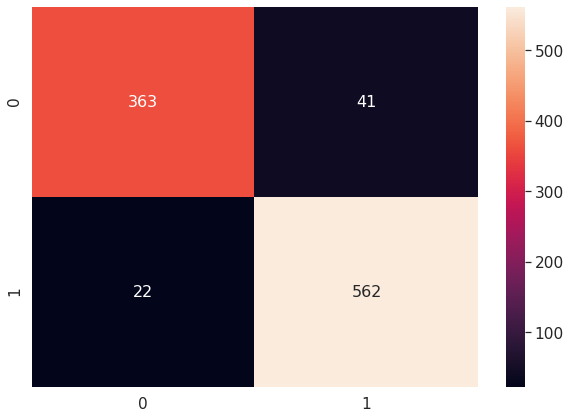

In [ ]:
gender_identifier = GenderIdentifier(config["base_dir"] + "TestingData/females", config["base_dir"] + "TestingData/males", config["model_dir"] + "females.gmm",config["model_dir"] + "males.gmm")
gender_identifier.process()